# noised_robot_model

移動・観測に生じる雑音・バイアスをモデルに追加する

## Robot

- なにか踏むかもしれない

    - 踏むまでの時間は指数分布に従う確率変数を都度ドロー
    
- 制御指令にバイアスが乗っているかもしれない

    - バイアスは正規分布に従う確率変数をドローし，その値を使い続ける
    
- スタックするかもしれない

    - スタックするまでの時間は指数分布に従う確率変数を都度ドロー
    
    - 抜け出すまでの時間は指数分布に従う確率変数を都度ドロー
    
- 誘拐されるかもしれない

    - 誘拐されるまでの時間は指数分布に従う確率変数を都度ドロー
    
    - 誘拐後の位置姿勢は指定された範囲の一様分布に従う確率変数を都度ドロー
    
## Sensor

- ノイズがあるかもしれない

    - 距離は，それに比例する標準偏差の正規分布に従う確率変数を都度ドロー
    
    - 角度は，一定の標準偏差の正規分布に従う確率変数を都度ドロー
    
- バイアスがのっているかもしれない

    - 正規分布に従う確率変数を都度ドロー
    
- ないはずのランドマークが観測されるかもしれない

    - 一様分布に従う確率変数を都度ドロー

- 見落としがあるかもしれない

    - 一様分布に従う確率変数を都度ドロー

- オクルージョンがあるかもしれない

    - 一様分布に従う確率変数を都度ドロー

In [4]:
from sys import path
path.append('../src/')

import importlib
from math import pi

import drawables
import pdfs
    
def reload():
    importlib.reload(drawables)
    importlib.reload(pdfs)
    
reload()

移動に対するノイズ

なにか踏んだら姿勢が少しずれる想定

いつ踏んでしまうかについては，指数分布に従うものとする

$$
p(x \mid \lambda) = \lambda \exp \left( -\lambda x \right)
$$

<IPython.core.display.Javascript object>


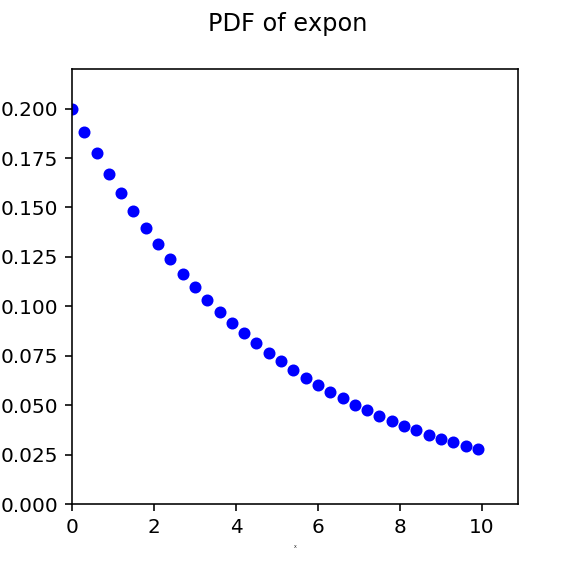

In [5]:
# 指数分布のプロット
import numpy as np
reload()

# 小石を踏むまで進む量の期待値
expected_travel_distance = 5.0
plotter = pdfs.ExponPdfPlotter(scale=expected_travel_distance)
plotter.plot([x for x in np.arange(0., 10., 0.3)])

<IPython.core.display.Javascript object>


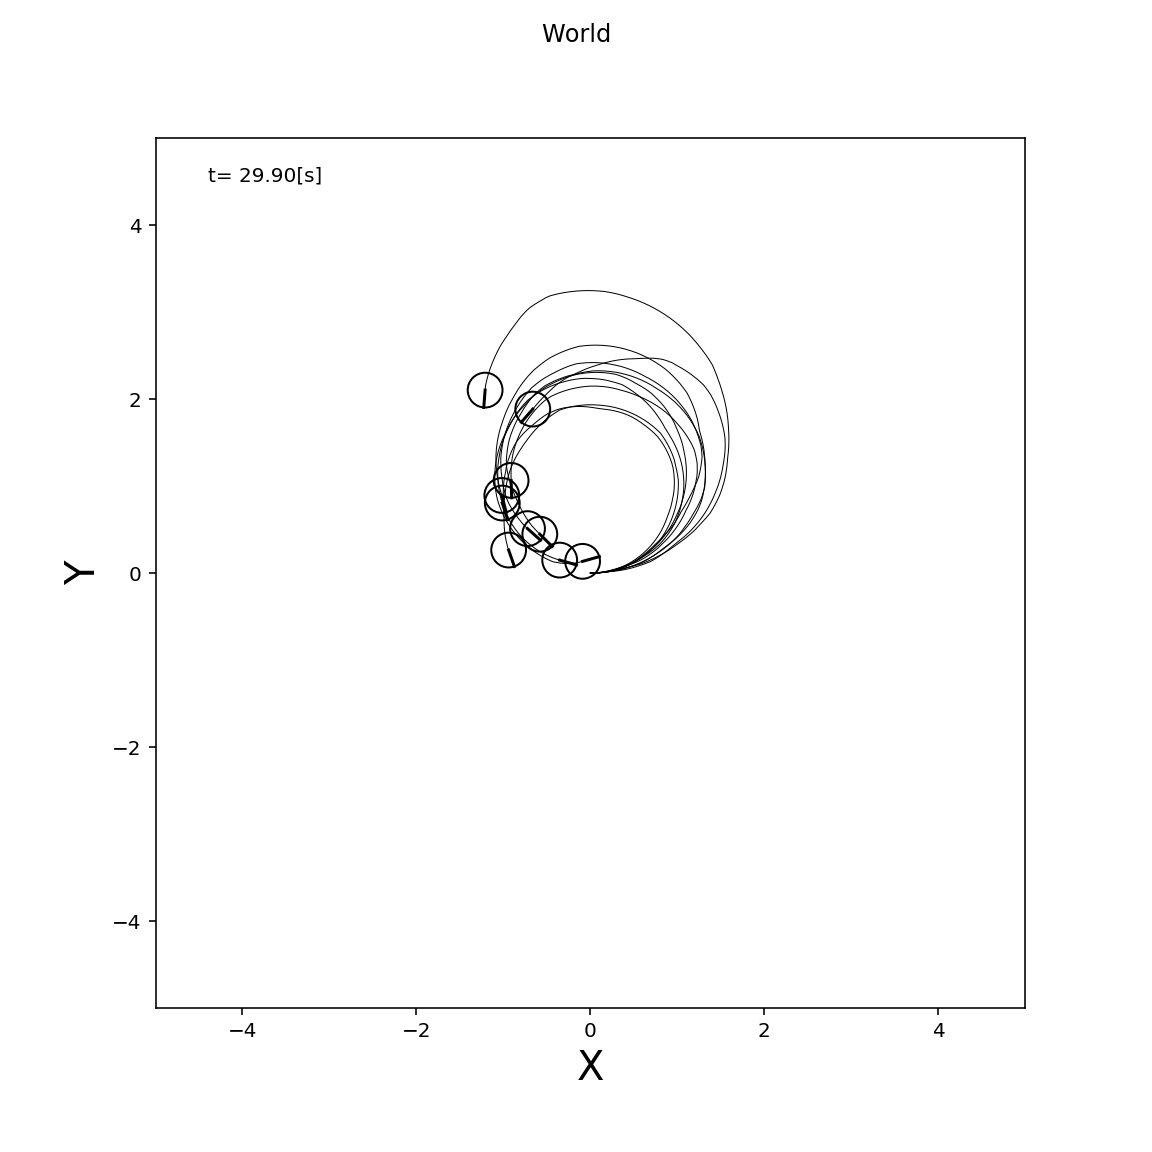

In [6]:
# なにか踏むことを考慮したときのロボット軌跡
# 10個ロボットを生成して，それぞれの軌跡を表示する
reload()

sim = drawables.Simulator(30., 0.1, debuggable=False)

for i in range(10):
    circling = drawables.DrawableSimpleAgent(0.2, 10./180.*pi)
    robot = drawables.DrawableRealRobot(
        np.array([0., 0., 0.]).T, sensor=None, agent=circling, color='black')
    sim.append(robot)
    
sim.draw()

制御指令にバイアスを与える

正規分布からドローしておいた値を使い続けることで実現する

<IPython.core.display.Javascript object>


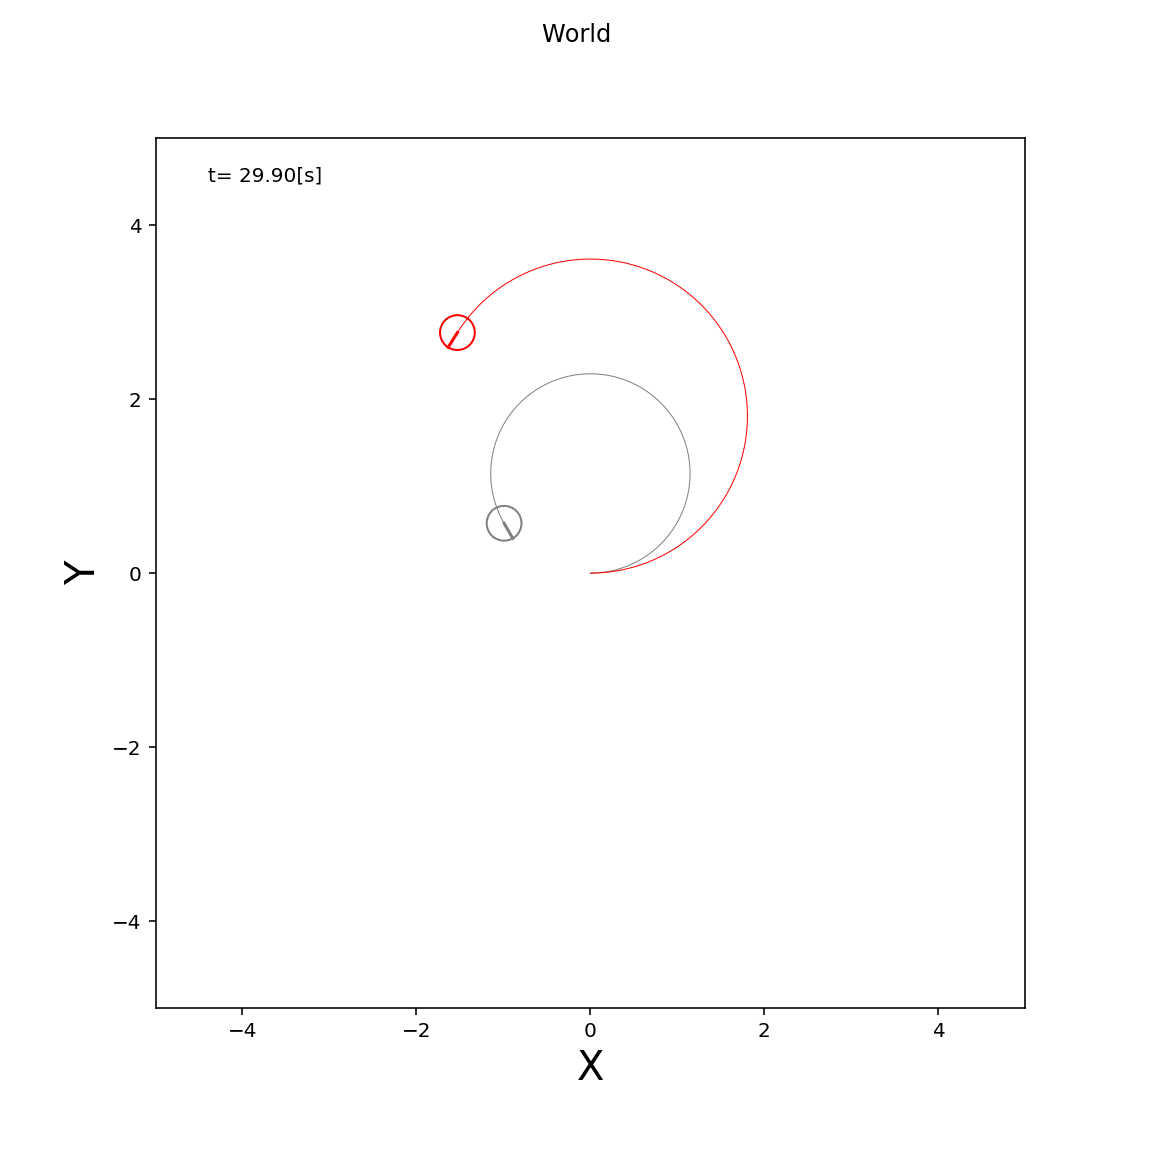

In [8]:
# バイアスの有無それぞれの場合でのロボット軌跡をみる
reload()
import copy

sim = drawables.Simulator(30., 0.1, debuggable=False)

circling = drawables.DrawableSimpleAgent(0.2, 10./180.*pi)

no_bias_robot = drawables.DrawableIdealRobot(
    np.array([0., 0., 0.]).T, sensor=None, agent=circling, color='gray')
bias_robot = drawables.DrawableRealRobot(
    np.array([0., 0., 0.]).T, sensor=None, agent=circling, color='red',
    noise_per_meter=0., bias_rate_stds=(0.2, 0.2))

sim.append(no_bias_robot)
sim.append(bias_robot)

sim.draw()

スタックしているかどうかのシミュレーション機能を追加した

スタックするまでにかかる時間，抜け出すまでにかかる時間はそれぞれ指数分布に従うとする

<IPython.core.display.Javascript object>


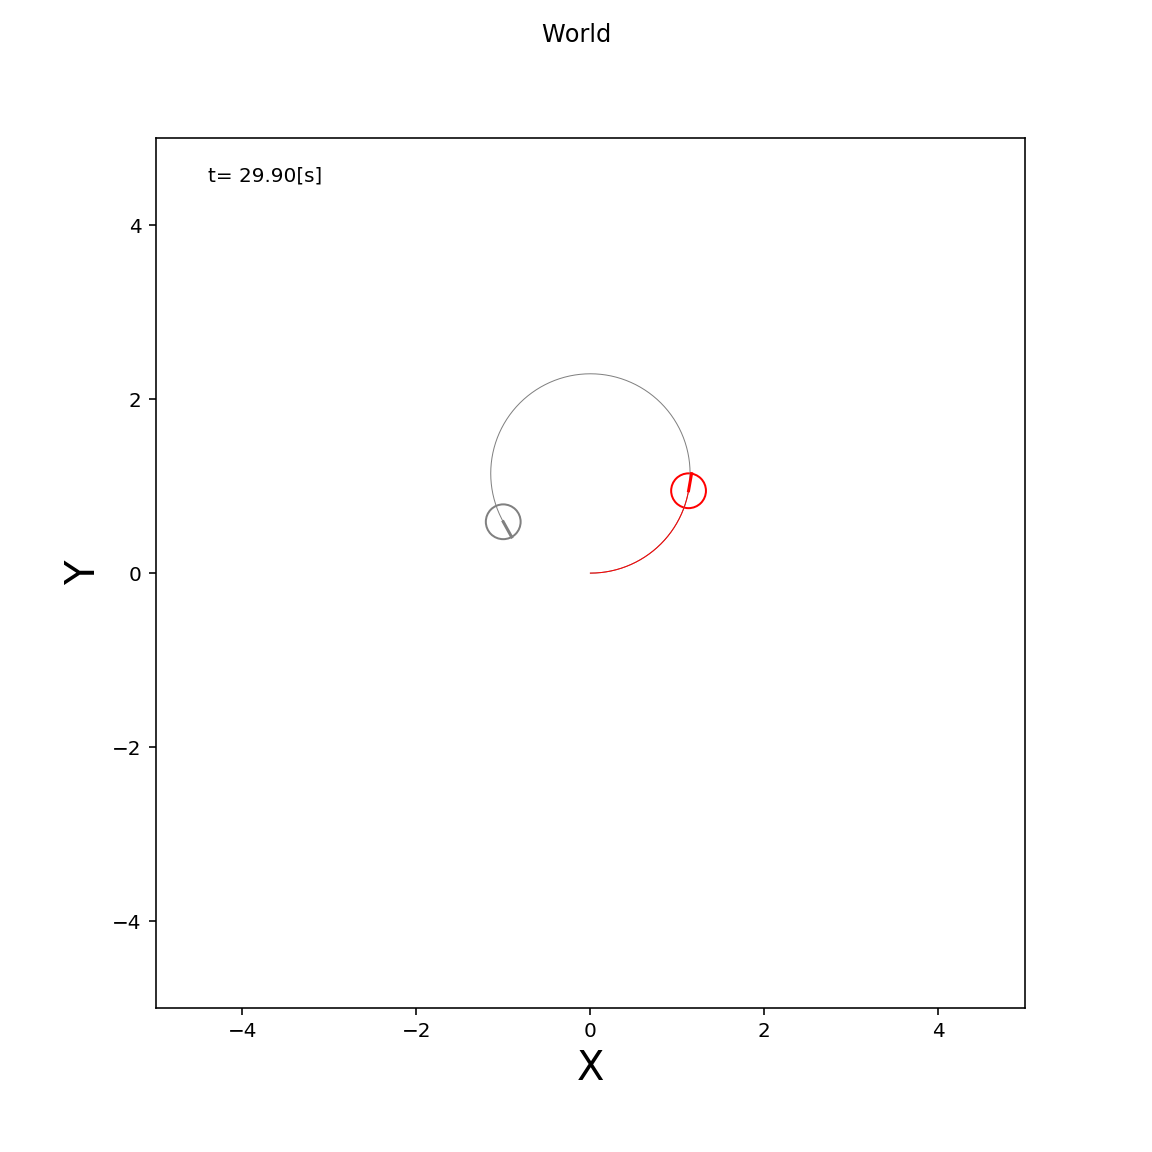

In [9]:
# みてみる
reload()
import copy

sim = drawables.Simulator(30., 0.1, debuggable=True)

circling = drawables.DrawableSimpleAgent(0.2, 10./180.*pi)

no_stuck_robot = drawables.DrawableIdealRobot(
    np.array([0., 0., 0.]).T, sensor=None, agent=circling, color='gray')
stuckable_robot = drawables.DrawableRealRobot(
    np.array([0., 0., 0.]).T, sensor=None, agent=circling, color='red',
    noise_per_meter=0., bias_rate_stds=(0.0, 0.0),
    expected_stuck_time=10., expected_escape_time=10.,
    expected_kidnap_time=1e100)

sim.append(no_stuck_robot)
sim.append(stuckable_robot)

sim.draw()

誘拐をシミュレートする

発生するまでの時間は指数分布の確率変数をドローする

誘拐後の位置姿勢は指定された範囲の一様分布の確率変数をドローする

ある領域$X \subset \mathcal X$ ($\subset$はサブセット)から$x \in X$を選ぶときの確率密度関数は

$$
p({\bf x} \mid X) = \left\{
    \begin{array}{11}
        \eta^{-1} & ({\bf x} \in X) \\
        0         & ({\bf x} \notin X)
    \end{array} \right.
$$

ここで

$$
\eta = \int_{{\bf x}^{\prime} \in X} 1 d{\bf \it x}^{\prime}
$$

<IPython.core.display.Javascript object>


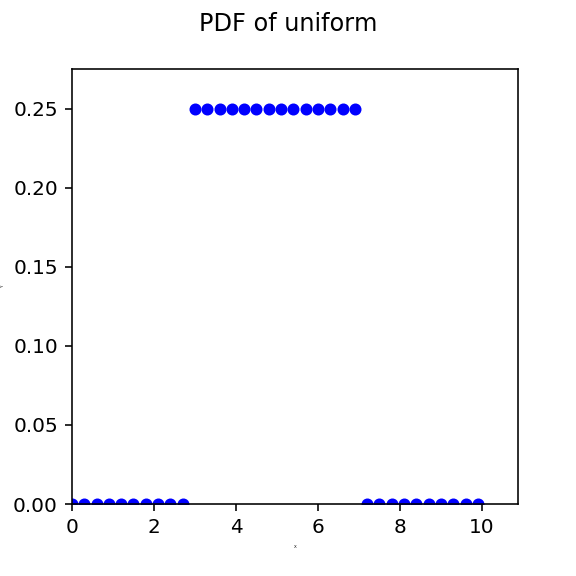

In [10]:
# 一様分布のプロット
import numpy as np
reload()

# locは値域の始点，scaleは終点
plotter = pdfs.UniformPdfPlotter(loc=3, scale=4)
plotter.plot([x for x in np.arange(0., 10., 0.3)])

<IPython.core.display.Javascript object>


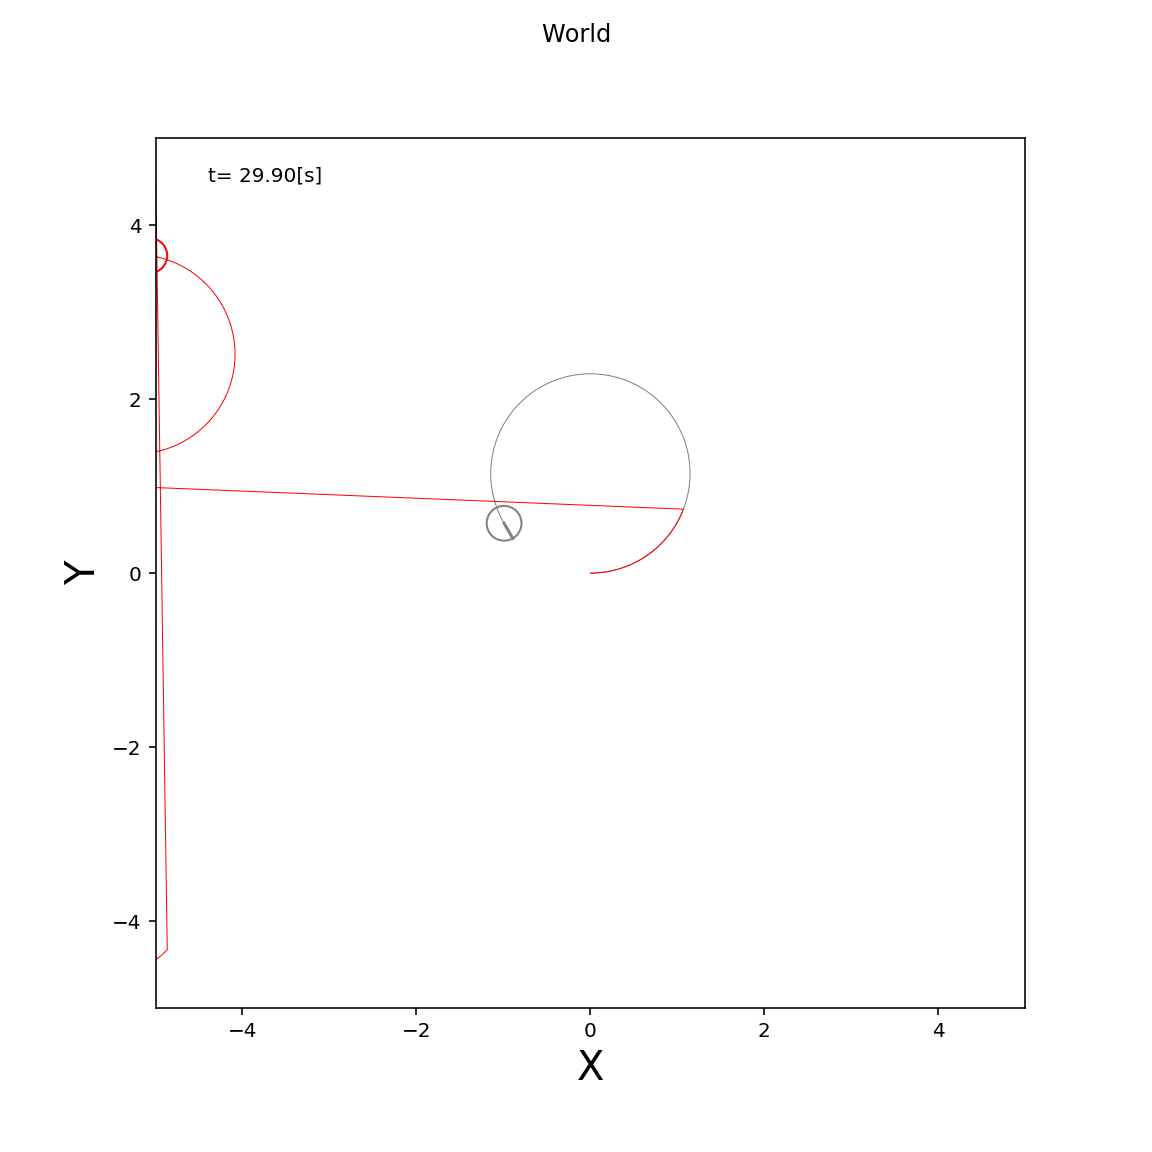

In [11]:
# 誘拐のシミュレート

# みてみる
reload()
import copy

sim = drawables.Simulator(30., 0.1, debuggable=False)

circling = drawables.DrawableSimpleAgent(0.2, 10./180.*pi)

ideal_robot = drawables.DrawableIdealRobot(
    np.array([0., 0., 0.]).T, sensor=None, agent=circling, color='gray')
kidnap_robot = drawables.DrawableRealRobot(
    np.array([0., 0., 0.]).T, sensor=None, agent=circling, color='red',
    noise_per_meter=0., bias_rate_stds=(0.0, 0.0),
    expected_stuck_time=1e100, expected_escape_time=0.,
    expected_kidnap_time=5.)

sim.append(ideal_robot)
sim.append(kidnap_robot)

sim.draw()

以上の実装により，状態遷移関数にノイズの項を追加したことになる

$$
{\bf \it x}_{t} = f({\bf \it x}_{t-1}, {\bf \it u}_{t}) + \epsilon_{t}
$$

なんか一意に${\bf \it x}_{t}$が決まる感があるけど，$\epsilon_{t}$なんかは状況により変わってくる

確率的な，あやふやな感じの形で表現するのが自然

状態方程式というよりは，確率モデル，状態遷移モデルと呼んだほうがよい

$$
{\bf \it x}_{t} \sim p({\bf \it x} \mid {\bf \it x}_{t-1}, {\bf \it u}_{t})
$$

状態${\bf \it x}_{t-1}$から制御指令${\bf \it u}_{t}$で移動したら次はどの状態にいるかを表す確率密度関数

センサーにもノイズを乗せる

まずは観測結果の距離と角度にノイズを与える

<IPython.core.display.Javascript object>


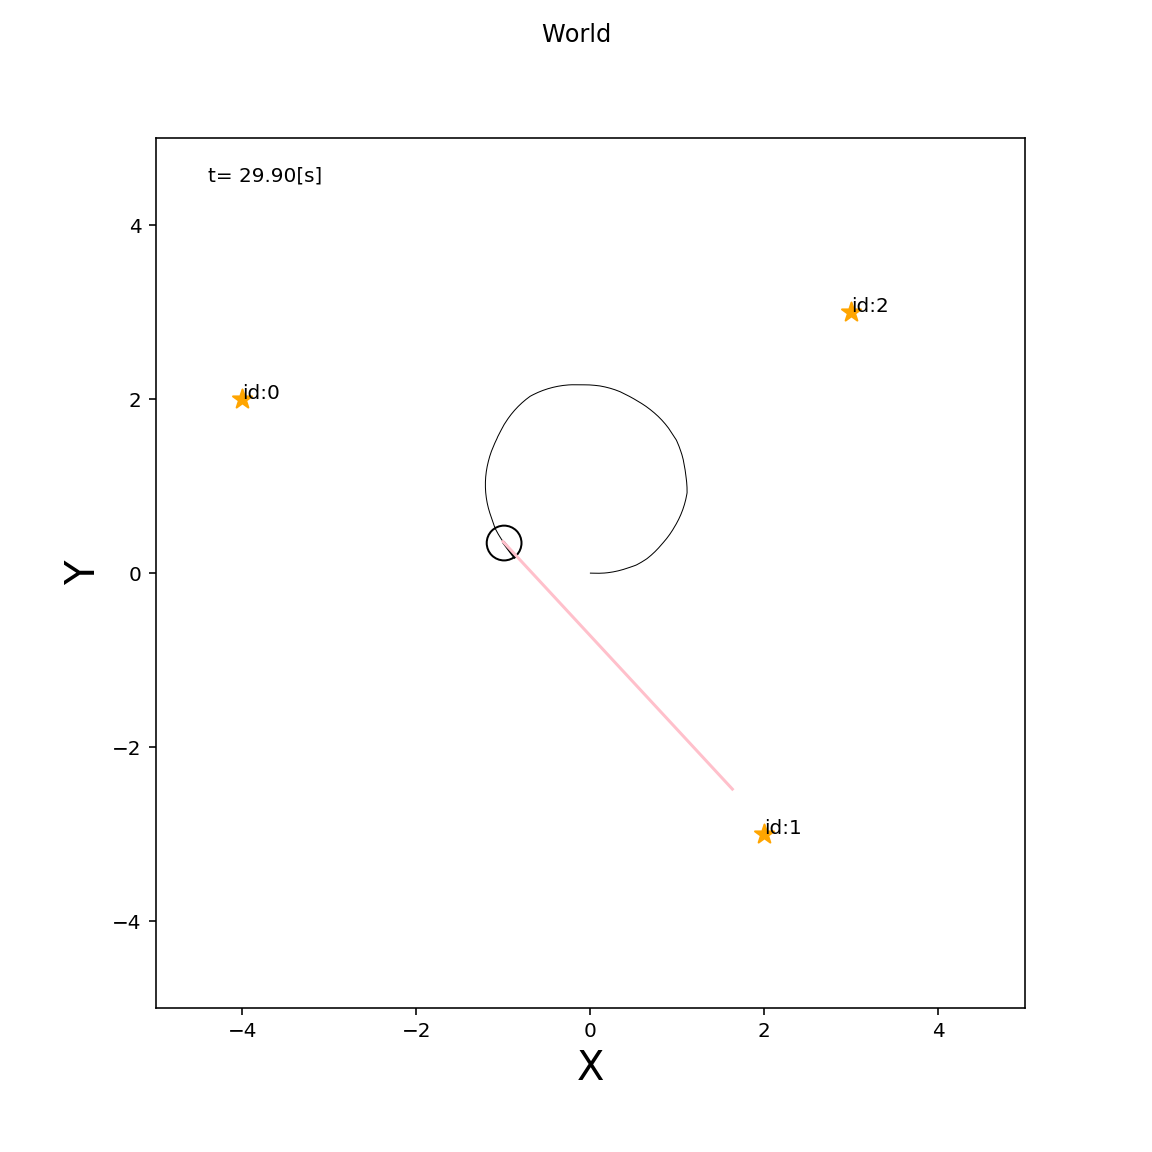

In [12]:
reload()

sim = drawables.Simulator(30., 0.1, debuggable=False)

m = drawables.DrawableMap()
m.append_landmark(drawables.DrawablePoint2DLandmark(-4., 2.))
m.append_landmark(drawables.DrawablePoint2DLandmark(2., -3.))
m.append_landmark(drawables.DrawablePoint2DLandmark(3., 3.))
sim.append(m)

circling = drawables.DrawableSimpleAgent(0.2, 10. / 180. * pi)
robot = drawables.DrawableRealRobot(
    np.array([0., 0., 0.]).T, sensor=drawables.DrawableCamera(m), agent=circling)
sim.append(robot)

sim.draw()

センサにバイアスを乗せる

事前に正規分布に従う確率変数をドローして，それを使い続ける

<IPython.core.display.Javascript object>


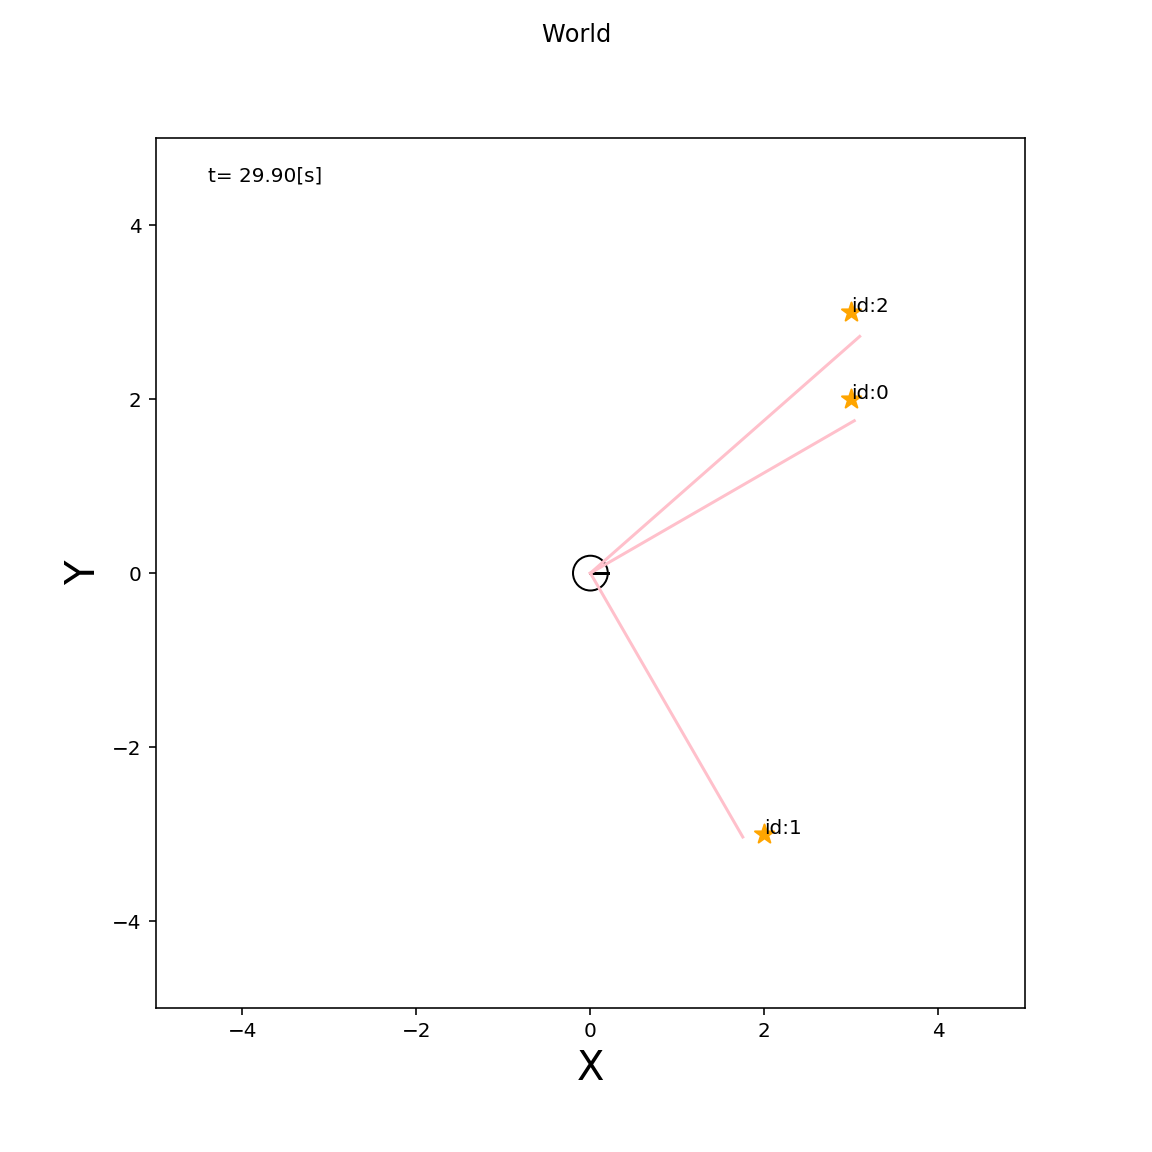

In [10]:
reload()

world = worlds.World(30., 0.1, debuggable=False)

m = maps.Map()
m.append_landmark(landmarks.Point2DLandmark(3., 2.))
m.append_landmark(landmarks.Point2DLandmark(2., -3.))
m.append_landmark(landmarks.Point2DLandmark(3., 3.))
world.append(m)

circling = agents.SimpleAgent(0., 0.)
robot = robots.Robot(
    np.array([0., 0., 0.]).T,
    sensor=sensors.Camera(
        m,
        distance_noise_rate=0., direction_noise=0.,
        distance_bias_rate_stddev=0.5, direction_bias_stddev=pi/180.*3),
    agent=circling)
world.append(robot)

world.draw()

見落としとオクルージョンを追加

<IPython.core.display.Javascript object>


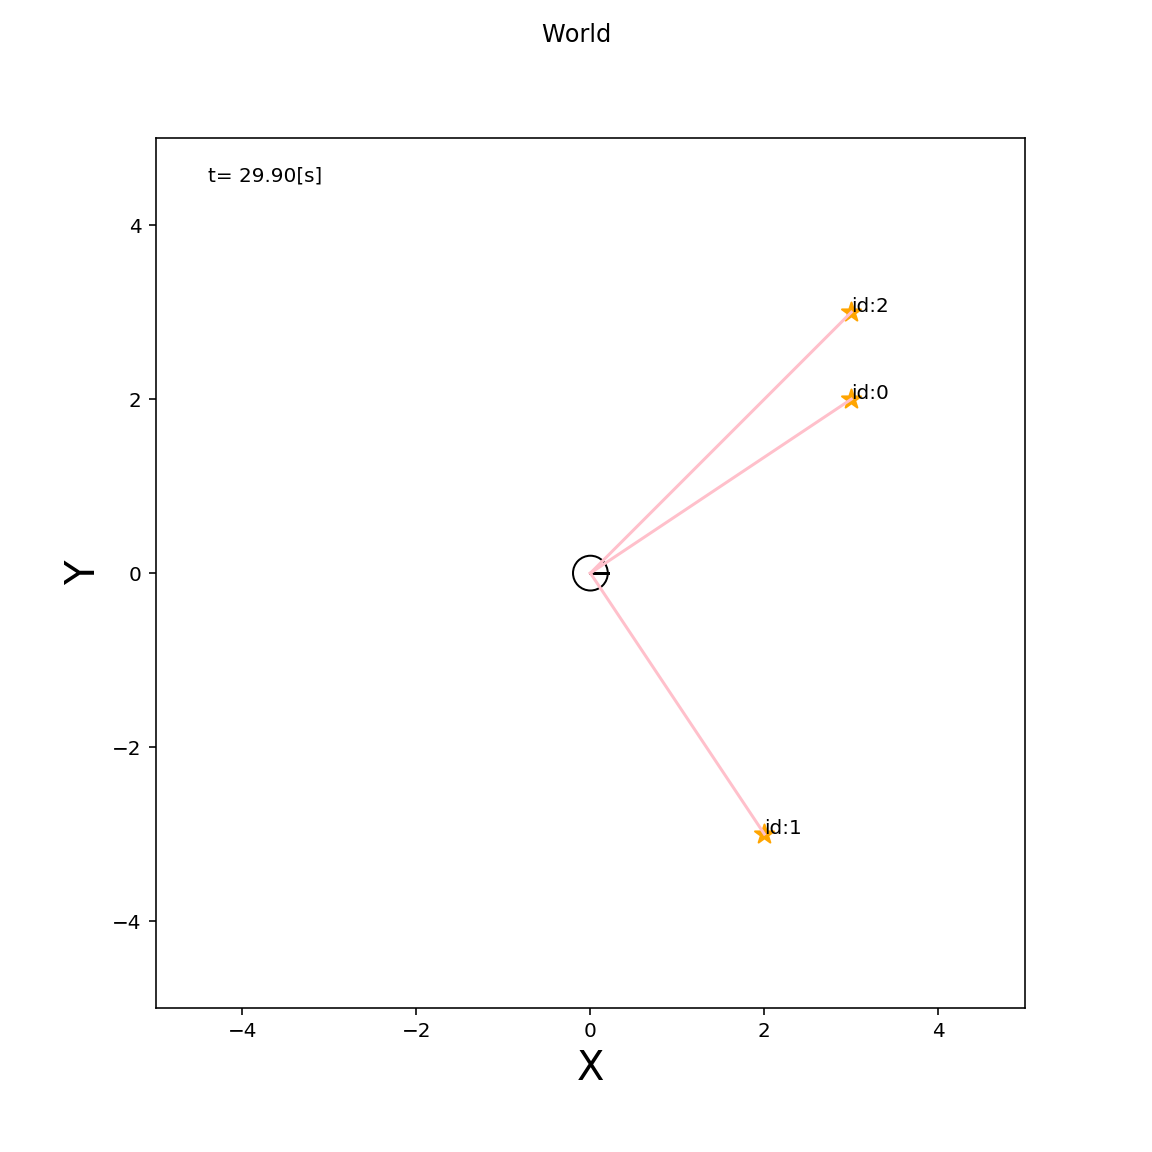

In [11]:
reload()
world = worlds.World(30., 0.1, debuggable=False)

m = maps.Map()
m.append_landmark(landmarks.Point2DLandmark(3., 2.))
m.append_landmark(landmarks.Point2DLandmark(2., -3.))
m.append_landmark(landmarks.Point2DLandmark(3., 3.))
world.append(m)

circling = agents.SimpleAgent(0., 0.)
robot = robots.Robot(
    np.array([0., 0., 0.]).T,
    sensor=sensors.Camera(
        m,
        distance_noise_rate=0., direction_noise=0.,
        distance_bias_rate_stddev=0., direction_bias_stddev=0.,
        phantom_prob=0.1,
        occulusion_prob=0.1),
    agent=circling)
world.append(robot)

world.draw()

観測方程式も確率的な考えをいれてノイズを考慮した感を出す

$$
{\bf \it z}_{t} \sim p({\bf \it z} \mid {\bf \it x}_{t})
$$

確率的な観測モデル

${\bf \it x}$がロボットの姿勢であるとき，ランドマーク$m_{j}$を観測すると，${\bf \it z}_{j}$は確率密度関数$p_{j}$で表される確率分布に従う，という意味

